# Glacier runoff model for La Paz, Bolivia

Current questions/issues:
- Unsure if glacier directory is up to date
- Continue on error is on (we didn't figure out how to avoid this)
- Multiprocessing is off

## <b> Step 1: Import necessary software packages for graphing and visualization

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely.geometry as shpg
import os

## <b> Step 2: import and set up OGGM software

In [2]:
from oggm import cfg, utils, workflow, tasks, graphics

In [40]:
# Define the directory path in your home directory
path = '/Users/ziggygoddard/Documents/summer24/OGGM_output' 

In [41]:
# work with parameters 
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir']=path

cfg.PARAMS['store_model_geometry'] = True
# cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error']=True #this is to avoid issues with the files with invalid geometries

#You can provide any other dataset to OGGM by setting the climate_file parameter in params.cfg

2024-06-20 15:26:36: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-06-20 15:26:36: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-06-20 15:26:36: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-06-20 15:26:37: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2024-06-20 15:26:37: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


## Step 3: Define glaciers for the run

In [43]:
# Download glacier outlines
# I assume I should access a newer version of the glacier directory?
utils.get_rgi_dir(version='62')  # path to the data after download

'/Users/ziggygoddard/OGGM/rgi/RGIV62'

In [6]:
# Get rgi region file for region 16 (South America)
# Update?
fr = utils.get_rgi_region_file(16, version='62')

In [7]:
# Read file as as geopandas
gdf = gpd.read_file(fr)

In [8]:
# Add basin shapefile
path = '~/Documents/summer24/LaPaz_dissolved.shp' # Is this what I want? Is it up to date?
basin = gpd.read_file(path)

In [9]:
# Select glaciers within the basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

In [10]:
# Select rgi id's from the gdf_sel file
rgi_ids = gdf_sel['RGIId']

In [11]:
rgi_ids

494     RGI60-16.00495
496     RGI60-16.00497
497     RGI60-16.00498
500     RGI60-16.00501
504     RGI60-16.00505
505     RGI60-16.00506
507     RGI60-16.00508
508     RGI60-16.00509
509     RGI60-16.00510
510     RGI60-16.00511
512     RGI60-16.00513
522     RGI60-16.00523
523     RGI60-16.00524
525     RGI60-16.00526
527     RGI60-16.00528
529     RGI60-16.00530
530     RGI60-16.00531
531     RGI60-16.00532
538     RGI60-16.00539
539     RGI60-16.00540
543     RGI60-16.00544
544     RGI60-16.00545
545     RGI60-16.00546
546     RGI60-16.00547
548     RGI60-16.00549
549     RGI60-16.00550
563     RGI60-16.00564
565     RGI60-16.00566
594     RGI60-16.00595
595     RGI60-16.00596
609     RGI60-16.00610
610     RGI60-16.00611
1441    RGI60-16.01447
1442    RGI60-16.01448
1443    RGI60-16.01449
Name: RGIId, dtype: object

## Step 4. Prepare glacier data

In [12]:
# Initiate glacier directory task for each glacier
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup'
gdirs = workflow.init_glacier_directories(rgi_ids,
                                           from_prepro_level=5,
                                           prepro_base_url=base_url,
                                         prepro_border=80)
## we have a problem with the 10th glacier.  Why is OGGM not continuing?
## Try: running this in a for loop, and/or removing problem glaciers
## this is up to date

2024-06-20 10:34:39: oggm.workflow: init_glacier_directories from prepro level 5 on 35 glaciers.
2024-06-20 10:34:39: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 35 glaciers
2024-06-20 10:34:39: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


In [13]:
type(gdirs)

list

In [14]:
# gdirs = []
# for r in rgi_ids:
#     try:
#         gdir_temp = workflow.init_glacier_directories(r,
#                                                    from_prepro_level=5,
#                                                    prepro_base_url=base_url,
#                                                  prepro_border=80)
#         gdirs.append(gdir_temp)
#     except:
#         print('Failed for {}'.format(r))
#         continue

## Does not make correct format of gdirs for later use; also doesn't report any errors
## better luck next time

# Step 5. Initiate climate runs

### I. Run constant climate commitment run

In [15]:
# Initiate run_with_hydro using constant climate
# I assume this stays the same?
# Changed 'gdir' to 'gdirs'
for g in gdirs:
    file_id = '_ct'
    tasks.run_with_hydro(g, run_task=tasks.run_constant_climate, nyears=100, y0=2014, halfsize=5, store_monthly_hydro=True, 
                     output_filesuffix=file_id);

In [16]:
# Export data from constant climate run and compile run output
import datetime
output_path = '~/Documents/summer24/{}-ct_compiled_output.nc'.format(datetime.date.today()) 
new_ds = utils.compile_run_output(gdirs, input_filesuffix=file_id, path=output_path)

2024-06-20 10:35:45: oggm.utils: Applying global task compile_run_output on 35 glaciers
2024-06-20 10:35:45: oggm.utils: Applying compile_run_output on 35 gdirs.


In [17]:
# Load in the glacier data from above (only when data has been saved)
export_date = '2024-06-20'
input_path = '~/Documents/summer24/{}-ct_compiled_output.nc'.format(export_date)
ct_ds = xr.open_dataset(input_path)

In [18]:
# Look at the new dataset
ct_ds

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 101, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 808B 0.0 1.0 2.0 ... 99.0 100.0
  * rgi_id                        (rgi_id) <U14 2kB 'RGI60-16.00495' ... 'RGI...
    hydro_year                    (time) int64 808B ...
    hydro_month                   (time) int64 808B ...
    calendar_year                 (time) int64 808B ...
    calendar_month                (time) int64 808B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 14kB ...
    volume_bsl                    (time, rgi_id) float32 14kB ...
    volume_bwl                    (time, rgi_id) float32 14kB ...
    area                          (time, rgi_id) float32 14kB ...
    length                        (time, rgi_id) float32 14kB ...
    calving                       (time, rgi_id) float32 14kB ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 170kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 170kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 170kB ...
    water_level                   (rgi_id) float32 140B ...
    glen_a                        (rgi_id) float32 140B ...
    fs                            (rgi_id) float32 140B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-06-20 14:35:46

### a. Historical run for reference climate period

In [19]:
# Run the historical period with a fixed geometry spinup
for g in gdirs:
    file_id = '_hist_hydro'
    tasks.run_with_hydro(g, run_task=tasks.run_from_climate_data,
                         fixed_geometry_spinup_yr=1990,  # this tells to do spinup
                         ref_area_from_y0=True,  # 
                         store_monthly_hydro=True,
                         output_filesuffix=file_id);
# I think i have to run this every time I start the kernel again so file_id hist_hydro exists for gcm use

In [20]:
# Export data from historic climate run and compile run output
import datetime
output_path = '~/Documents/summer24/{}-hist_hydro_compiled_output.nc'.format(datetime.date.today()) 
new_ds = utils.compile_run_output(gdirs, input_filesuffix=file_id, path=output_path)

2024-06-20 10:35:57: oggm.utils: Applying global task compile_run_output on 35 glaciers
2024-06-20 10:35:57: oggm.utils: Applying compile_run_output on 35 gdirs.


In [21]:
# Load in the glacier data from above (only when data has been saved)
export_date = '2024-06-20'
input_path_hist = '~/Documents/summer24/{}-hist_hydro_compiled_output.nc'.format(export_date)
hist_ds = xr.open_dataset(input_path_hist)

### b. Projection run

<b> Remember: you need to change the GCM for bp and bt

In [22]:
# # Process climate data for each GCM 

# # name the gcm that is currently used
# # CHANGE GCM TO DOWNLOAD A DIFFERENT ONE
# current_gcm = 'CCSM4'

# # identify which gcms ('poorly behaved') have only 3 rcp scenarios instead of 4
# poorly_behaved = ['CNRM-CM5', 'CanESM2', 'MPI-ESM-LR']

# # import climate data from where it is stored within oggm
# ## Remember to change name of gcm each time this is run! 
# ## Note: I have tried to make this more efficient, but can't get the {} to work right
# from oggm.shop import gcm_climate
# bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_{}_{}_r1i1p1_g025.nc' #precipitation
# bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_{}_{}_r1i1p1_g025.nc' #temperature

# # process climate data for each rcp scenario
# if current_gcm in poorly_behaved:
#     for rcp in ['rcp26', 'rcp45', 'rcp85']:
#         # Download the files
#         ft = utils.file_downloader(bt.format(current_gcm, rcp))
#         fp = utils.file_downloader(bp.format(current_gcm, rcp))
#         # bias correct them
#         for g in gdirs:
#             workflow.execute_entity_task(gcm_climate.process_cmip_data, [g],
#                                          filesuffix='_{}_{}'.format(current_gcm, rcp),  # recognize the climate file for later
#                                          fpath_temp=ft,  # temperature projections
#                                          fpath_precip=fp,  # precip projections
#                                              );
# else:
#     for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
#         # Download the files
#         ft = utils.file_downloader(bt.format(current_gcm, rcp))
#         fp = utils.file_downloader(bp.format(current_gcm, rcp))
#         # bias correct them
#         for g in gdirs:
#             workflow.execute_entity_task(gcm_climate.process_cmip_data, [g],
#                                          filesuffix='_{}_{}'.format(current_gcm, rcp),  # recognize the climate file for later
#                                          fpath_temp=ft,  # temperature projections
#                                          fpath_precip=fp,  # precip projections
#                                              );

In [23]:
# # Run the model with hydrologic output for each rcp scenario
# if current_gcm in poorly_behaved:
#     for g in gdirs:
#         for rcp in ['rcp26', 'rcp45', 'rcp85']:
#             rid = '_{}_{}'.format(current_gcm, rcp)
#             tasks.run_with_hydro(g, run_task=tasks.run_from_climate_data,
#                                  climate_filename='gcm_data',  # use gcm_data, not climate_historical
#                                  climate_input_filesuffix=rid,  # use the chosen scenario (gcm and rcp)
#                                  init_model_filesuffix='_hist_hydro',  # start using hist data
#                                  ref_geometry_filesuffix='_hist_hydro',  # also use this as area reference
#                                  ref_area_from_y0=True,  # and keep the same reference area as for the historical simulations
#                                  output_filesuffix=rid,  # recognize the run for later
#                                  store_monthly_hydro=True,  # add monthly diagnostics
#                                  );
# else:
#     for g in gdirs:
#         for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
#             rid = '_{}_{}'.format(current_gcm, rcp)
#             tasks.run_with_hydro(g, run_task=tasks.run_from_climate_data,
#                                  climate_filename='gcm_data',
#                                  climate_input_filesuffix=rid, 
#                                  init_model_filesuffix='_hist_hydro', 
#                                  ref_geometry_filesuffix='_hist_hydro',  
#                                  ref_area_from_y0=True, 
#                                  output_filesuffix=rid, 
#                                  store_monthly_hydro=True, 
#                                  );

In [24]:
# new_ds_nor = utils.compile_run_output(gdirs, input_filesuffix=rid)
# new_ds_nor

In [25]:
# # Export data from climate run and compile run output
# import datetime
# if current_gcm in poorly_behaved:
#     for rcp in ['rcp26', 'rcp45', 'rcp85']:
#         rid = '_{}_{}'.format(current_gcm, rcp) #same rid as in step above
#         output_path = '~/Documents/summer24/{}-gcm_data_{}_{}_compiled_output.nc'.format(datetime.date.today(), current_gcm, rcp) #define name for file 
#         new_ds = utils.compile_run_output(gdirs, input_filesuffix=rid, path=output_path) #compile all rcp outputs into one file
# else:
#     for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
#         rid = '_{}_{}'.format(current_gcm, rcp)
#         output_path = '~/Documents/summer24/{}-gcm_data_{}_{}_compiled_output.nc'.format(datetime.date.today(), current_gcm, rcp) 
#         new_ds = utils.compile_run_output(gdirs, input_filesuffix=rid, path=output_path)

## II. Run CMIP6 projection run

In [26]:
# Is this something I need to/should do? https://docs.oggm.org/en/latest/climate-data.html
from oggm.tasks import process_w5e5_data

In [27]:
# the issue here is with ssp245, not the models; why? probably in oggm somewhere but that will take some digging

from oggm.shop import gcm_climate

all_members = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
               'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2']

# Download the three main SSPs
for member in all_members:
    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, # isimip is where the problem is; ssp245 won't work with this; see https://www.isimip.org/documents/413/ISIMIP3b_bias_adjustment_fact_sheet_Gnsz7CO.pdf
                                     ssp = ssp,
                                     # gcm member -> you can choose another one
                                     member=member,
                                     # recognize the climate file for later
                                     output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                     );

2024-06-20 10:35:58: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 35 glaciers
2024-06-20 10:35:58: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2024-06-20 10:36:46: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 35 glaciers
2024-06-20 10:36:46: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2024-06-20 10:38:54: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 35 glaciers
2024-06-20 10:38:54: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2024-06-20 10:39:42: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 35 glaciers
2024-06-20 10:39:42: oggm.workflow: WARNING

In [28]:
# # Run the model with hydrologic output for each rcp scenario
# for g in gdirs:
#         for ssp in ['ssp126', 'ssp370', 'ssp585']:
#             rid = '_{}_{}'.format(member, ssp)
#             tasks.run_with_hydro(g, run_task=tasks.run_from_climate_data,
#                                  climate_filename='gcm_data',
#                                  climate_input_filesuffix=rid, 
#                                  init_model_filesuffix='_hist_hydro', 
#                                  ref_geometry_filesuffix='_hist_hydro',  
#                                  ref_area_from_y0=True, 
#                                  output_filesuffix=rid, 
#                                  store_monthly_hydro=True, 
#                                  );

In [29]:
# From OGGM; see how this differs from og code above
# Run the model with hydrologic output for each rcp scenario
for ssp in ['ssp126', 'ssp370', 'ssp585']: # add ssp245
    rid = f'_ISIMIP3b_{member}_{ssp}' # I don't know how/if this will affect the pathway in the next notebook?
    workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                             run_task=tasks.run_from_climate_data, ys=2020,
                             # use gcm_data, not climate_historical
                             climate_filename='gcm_data',
                             # use the chosen scenario
                             climate_input_filesuffix=rid,
                             # this is important! Start from 2020 glacier
                             init_model_filesuffix='_spinup_historical',
                             # recognize the run for later
                             output_filesuffix=rid,
                             # add monthly diagnostics
                             store_monthly_hydro=True);

2024-06-20 10:48:57: oggm.workflow: Execute entity tasks [run_with_hydro] on 35 glaciers
2024-06-20 10:48:57: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2024-06-20 10:49:17: oggm.workflow: Execute entity tasks [run_with_hydro] on 35 glaciers
2024-06-20 10:49:17: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.
2024-06-20 10:49:38: oggm.workflow: Execute entity tasks [run_with_hydro] on 35 glaciers
2024-06-20 10:49:38: oggm.workflow: WARNING: you are trying to run an entity task on 35 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


In [30]:
# This is unchanged
new_ds_nor = utils.compile_run_output(gdirs, input_filesuffix=rid)

2024-06-20 10:49:59: oggm.utils: Applying global task compile_run_output on 35 glaciers
2024-06-20 10:49:59: oggm.utils: Applying compile_run_output on 35 gdirs.


In [31]:
# # Export data from climate run and compile run output
# import datetime
# for ssp in ['ssp126', 'ssp370', 'ssp585']:
#         rid = '_{}_{}'.format(member, ssp) #same rid as in step above
#         output_path = '~/Documents/summer24/{}-gcm_data_{}_{}_compiled_output.nc'.format(datetime.date.today(), member, ssp) #define name for file 
#         new_ds = utils.compile_run_output(gdirs, input_filesuffix=rid, path=output_path) #compile all rcp outputs into one file

In [32]:
# Changes explained by ChatGPT; again, unsure how this will affect pathway
# Export data from climate run and compile run output
import datetime
for ssp in ['ssp126', 'ssp370', 'ssp585']:
    # Update the rid format to match the first cell
    rid = f'_ISIMIP3b_{member}_{ssp}'
    # Define the output path with proper path handling
    output_path = os.path.expanduser(f'~/Documents/summer24/{datetime.date.today()}-gcm_data_{member}_{ssp}_compiled_output.nc')
    # Compile all rcp outputs into one file
    new_ds = utils.compile_run_output(gdirs, input_filesuffix=rid, path=output_path) #compile all rcp outputs into one file

2024-06-20 10:50:00: oggm.utils: Applying global task compile_run_output on 35 glaciers
2024-06-20 10:50:00: oggm.utils: Applying compile_run_output on 35 gdirs.
2024-06-20 10:50:01: oggm.utils: Applying global task compile_run_output on 35 glaciers
2024-06-20 10:50:01: oggm.utils: Applying compile_run_output on 35 gdirs.
2024-06-20 10:50:02: oggm.utils: Applying global task compile_run_output on 35 glaciers
2024-06-20 10:50:02: oggm.utils: Applying compile_run_output on 35 gdirs.


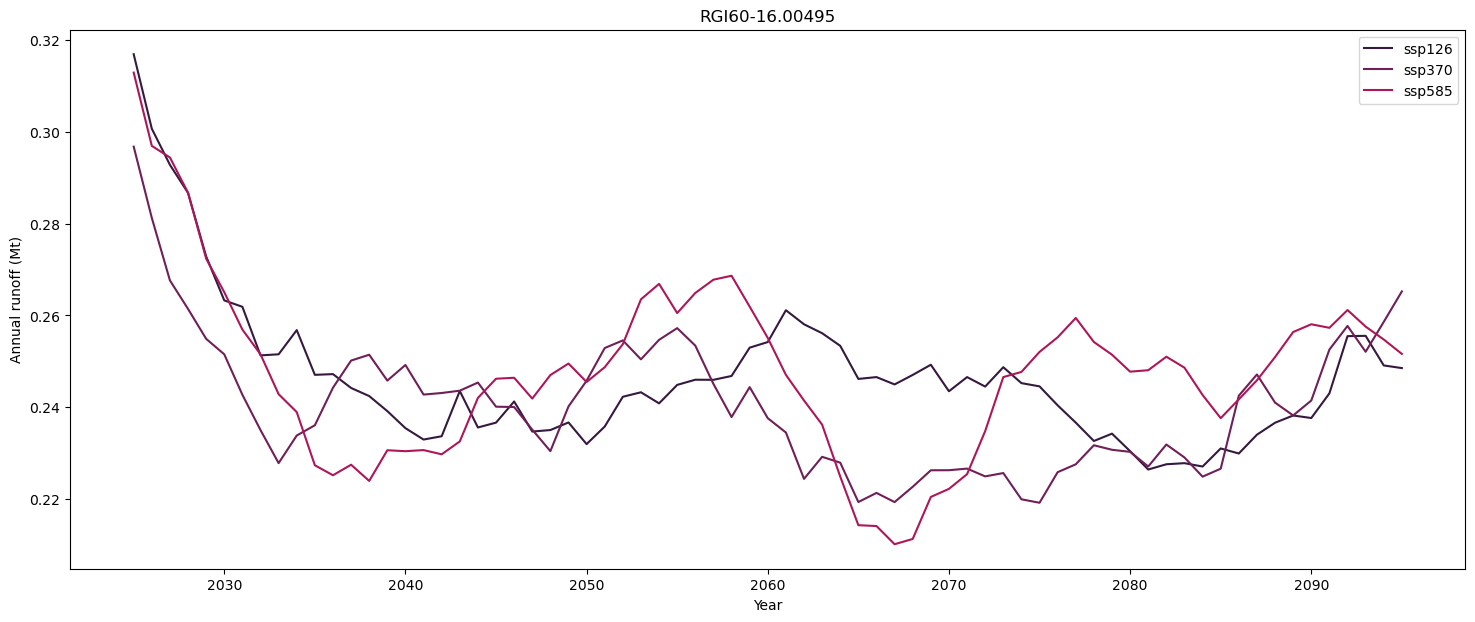

In [33]:
# OGGM said to do this; not sure if its necessary, but at least it works
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop over all scenarios
for i, ssp in enumerate(['ssp126', 'ssp370', 'ssp585']):
    file_id = f'_ISIMIP3b_{member}_{ssp}'
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1).rolling(window=11, center=True).mean()
    df_roll.plot(ax=ax, label=ssp, color=sns.color_palette("rocket")[i])

ax.set_ylabel('Annual runoff (Mt)'); ax.set_xlabel('Year'); plt.title(gdirs[0].rgi_id); plt.legend();